<div id="colab_button">
  <h1>Data cleaning: Normalization in BastionLab</h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.7/docs/docs/tutorials/normalization.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>
______________________________________________________


Data normalization is a common data pre-processing technique which refers to scaling data values in so that the new values are within a specific range, typically -1 to 1, or 0 to 1.  It is often prior to ML model fitting and helps to remove bias between features or values of different scales.

Let's take an example. Imagine we have a dataset of houses, with columns including price, number of bedrooms, size in square meters etc. All these attributes have values in different ranges in terms of magnitude- the house price might be from 100,000 to 2 million euros, whilst the rooms might range from 1-5 bedrooms. This can cause a bias where the larger values are given more weight than lower values, which can affect the performance of the model.

There are various scaling methods which solve this problem by scaling all values to the same range and in BastionLab we have implemented some of the most common methods for you: z-score or standard scaling (also referred to as standardization), min/max scaling (also referred to as normalization), mean scaling, maximum absolute scaling and median and quantile scaling.

In this tutorial, we are going to take a look at each of these methods and how to use them.

## Pre-requisites

________________________________________________

### Installation

In order to run this notebook, we need to:
- Have [Python3.7](https://www.python.org/downloads/) (or greater) and [Python Pip](https://pypi.org/project/pip/) installed
- Install [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/)

We'll do so by running the code block below. 

>If you are running this notebook on your machine instead of [Google Colab](https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.6/docs/docs/tutorials/data_cleaning.ipynb), you can see our [Installation page](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) to find the installation method that best suits your needs.

In [4]:
# pip packages
!pip install bastionlab

!pip install bastionlab_server

### Launch and connect to the server

In [5]:
# launch bastionlab_server test package
import bastionlab_server

srv = bastionlab_server.start()

>*Note that the bastionlab_server package we install here was created for testing purposes. You can also install BastionLab server using our Docker image or from source (especially for non-test purposes). Check out our [Installation Tutorial](../getting-started/installation.md) for more details.*

In [6]:
# connecting to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

### Create an upload the dataframe to the server

For this tutorial, we'll create a dataset with four columns and rows of numerical values, including a column of floats.

In [7]:
import polars as pl

df1 = pl.DataFrame(
    {
        "Col A": [180000, 360000, 230000, 60000],
        "Col B": [110, 905, 230, 450],
        "Col C": [18.9, 23.4, 14.0, 13.5],
        "Col D": [1400, 1800, 1300, 1500],
    }
)


We'll quickly upload the dataset to the server with an open safety policy. This will allows us to print out the dataset in full for demonstrative purposes without having to approve any data access requests. You can check out how to define a safe privacy policy [here](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/defining_policy_privacy/).

In [8]:
from bastionlab.polars.policy import Policy, TrueRule, Log

policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log(), savable=True)

rdf = client.polars.send_df(df1, policy=policy)

<div class="warning">
<b>This policy is not suitable for production.</b> Please note that we <i>only</i> use it here for demonstration purposes! <br></div> 

## Scaling methods
__________________________________________________________

### Z-score (standardization) scaling

Applying Z-score scaling to data is a common practice before training ML algorithms on a dataset. The z-score method (also called standardization) rescales the data by subtracting the mean from all the data points and then dividing the result by the standard deviation of the data.

Mathematically, this is written as: `(x-u)/s` where `u` refers to the mean value and `s` refers to the standard deviation.

We can use the z-score method in BastionLab by calling the `zscore_scale` method on our RemoteLazyFrame and providing the name or list of names of columns we wish z-score scaling to be performed on as the only argument. If we want to scale all columns, we can pass the method the `rdf.columns` attribute to quickly get a list of all columns in our dataset.

In [9]:
columns = ["Col A", "Col B", "Col C", "Col D"]
z = rdf.zscore_scale(columns)
z.collect().fetch()

Col A,Col B,Col C,Col D
f64,f64,f64,f64
-0.221422,-0.895492,0.311486,-0.46291
1.227884,1.373564,1.278167,1.38873
0.181163,-0.552993,-0.741122,-0.92582
-1.187625,0.074922,-0.848531,0.0


We can visualize the scaled data using our barplot method.

But first we need to manipulate the data to get it into the right format for the visualization. 

The aim is to see each column represented by a different color and group them by their row. This means we need to convert our table to one with a `Row` column, listing the original row the value was part of (0, 1, 2 or 3), a `Column` column which lists which column the value originally belong to, Col A, Col B, Col C or Col D and a `Value` column with the values we want to display.

So we should end up with a table like this:

`Row	    Column	    Value
0       "Col A"     -0.221422

1       "Col A"     1.227884

2       "Col A"     0.181163

3       "Col A"     -1.187625

...     ...         ...`

To do this, we first will add an index using the `with_row_count`() method and specify the name of this new column as `Row`. We can then use the `melt` function, specifying the index as our new `Row` column and the `value_vars`, which are the values which will end up in our `Value` column, to be taken from the four original columns: Col A, Col B, Col C and Col D.

Finally, we can call the `barplot` method with our `Row` column as the `x` value, our `Value` column as the `y` value and important our `Column` column as the `hue` value. 

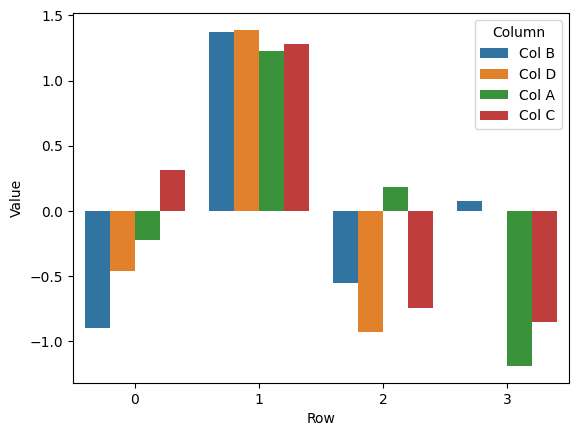

In [10]:
z = z.with_row_count("Row").melt(
    id_vars="Row",
    value_vars=["Col A", "Col B", "Col C", "Col D"],
    variable_name="Column",
    value_name="Value",
)
z.barplot(x="Row", y="Value", hue="Column")

### Min/max (normalization) scaling

The min/max method (often called normalization) rescales the feature to a range of [0,1] by subtracting the overall minimum value of the data and then dividing the result by the difference between the minimum and maximum values.

The min/max method is commonly used for data scaling where the maximum and minimum values for data points are known in advance, for example, image pixels with values between 0 and 255.

We can apply min/max normalization to one or multiple columns by calling the `minmax_scale` method on our `RemoteLazyFrame` with either the string name of one column or a list of string names of multiple columns.

In [11]:
mm = rdf.minmax_scale(rdf.columns)
mm.collect().fetch()

Col A,Col B,Col C,Col D
f64,f64,f64,f64
0.4,0.0,0.545455,0.2
1.0,1.0,1.0,1.0
0.566667,0.150943,0.050505,0.0
0.0,0.427673,0.0,0.4


We will again visualize this as a barplot.

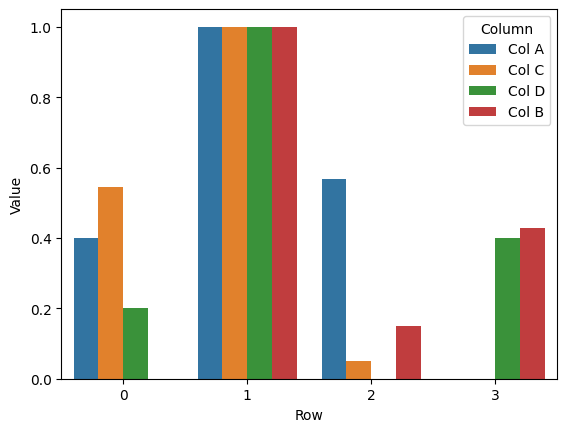

In [12]:
mm = mm.with_row_count("Row").melt(
    id_vars="Row",
    value_vars=["Col A", "Col B", "Col C", "Col D"],
    variable_name="Column",
    value_name="Value",
)
mm.barplot(x="Row", y="Value", hue="Column")

### Maximum Absolute scaling

Maximum absolute scaling rescales each feature between -1 and 1 by dividing each data point by its maximum absolute value.

We can apply maximum absolute normalization to one or multiple columns by calling the `max_abs` method on our `RemoteLazyFrame` with either the string name of one column or a list of string names of multiple columns.

In [13]:
ma = rdf.max_abs_scale(columns)
ma.collect().fetch()

Col A,Col B,Col C,Col D
f64,f64,f64,f64
0.5,0.121547,0.807692,0.777778
1.0,1.0,1.0,1.0
0.638889,0.254144,0.598291,0.722222
0.166667,0.497238,0.576923,0.833333


Let's visualize this again with barplot.

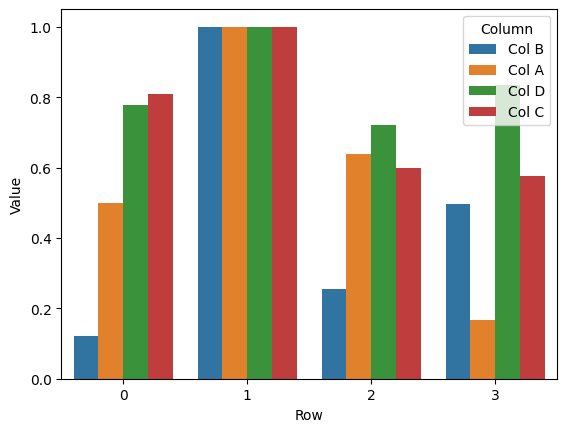

In [14]:
ma = ma.with_row_count("Row").melt(
    id_vars="Row",
    value_vars=["Col A", "Col B", "Col C", "Col D"],
    variable_name="Column",
    value_name="Value",
)
ma.barplot(x="Row", y="Value", hue="Column")

### Mean scaling

Mean scaling is the same as min/max scaling, except for it is the mean value that is subtracted from data points, rather than the minimum value. Like with Min/Max scaling, mean scaling is commonly used where the maximum and minimum values for data points are known in advance.

We can apply mean scaling to one or multiple columns by calling the `mean_scale` method on our `RemoteLazyFrame` with either the string name of one column or a list of string names of multiple columns- and we will continue to visualize the result of this in the code block that follows!

In [15]:
mean = rdf.mean_scale(columns)
mean.collect().fetch()

Col A,Col B,Col C,Col D
f64,f64,f64,f64
0.786885,0.0,0.907563,0.333333
1.967213,1.651948,1.663866,1.666667
1.114754,0.249351,0.084034,0.0
0.0,0.706494,0.0,0.666667


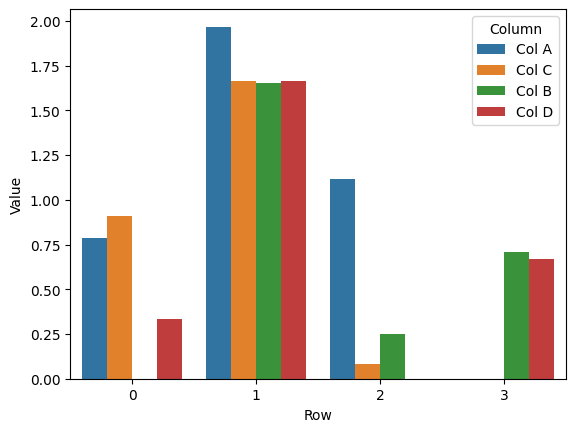

In [16]:
mean = mean.with_row_count("Row").melt(
    id_vars="Row",
    value_vars=["Col A", "Col B", "Col C", "Col D"],
    variable_name="Column",
    value_name="Value",
)
mean.barplot(x="Row", y="Value", hue="Column")

### Median and quantile scaling

The final scaling method we provide is median and quantile scaling (also known as robust scaling). This involves subtract the median value from data points and dividing the result by the IQR (inter-quartile range).

This method is commonly used for datasets with large numbers of outliers.

To this method, as with the other scaling methods, we call the relevant method, `median_quantile`, on our `RemoteLazyFrame` with either the string name of one column or a list of string names of multiple columns! We will again follow up by visualizing the output!

In [17]:
mq = rdf.mean_scale(columns)
mq.collect().fetch()

Col A,Col B,Col C,Col D
f64,f64,f64,f64
0.786885,0.0,0.907563,0.333333
1.967213,1.651948,1.663866,1.666667
1.114754,0.249351,0.084034,0.0
0.0,0.706494,0.0,0.666667


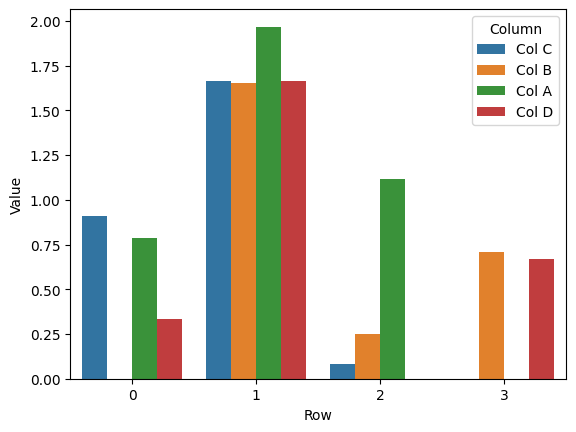

In [18]:
mq = mq.with_row_count("Row").melt(
    id_vars="Row",
    value_vars=["Col A", "Col B", "Col C", "Col D"],
    variable_name="Column",
    value_name="Value",
)
mq.barplot(x="Row", y="Value", hue="Column")

This brings us to the end of this introduction into BastionLab's normalization features. We can now close our connection with the server and stop the server instance.

In [19]:
connection.close()
bastionlab_server.stop(srv)